In [203]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

# IMDB

In [204]:
df = pd.read_csv('imdb.csv')
df = df.drop_duplicates()
df = df[~((df.Rate == 'No Rate') | (df.Votes == 'No Votes'))]
df.Votes = df.Votes.str.replace(',', '').astype(int)
df.Rate = df.Rate.astype(float)

df.head()

,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
0,No Time to Die,2021,7.6,107163,"Action, Adventure, Thriller",163,Film,PG-13,-,Mild,Moderate,Mild,Mild,Moderate
1,The Guilty,2021,6.3,64375,"Crime, Drama, Thriller",90,Film,R,-,None,None,Severe,None,Moderate
2,The Many Saints of Newark,2021,6.4,27145,"Crime, Drama",120,Film,R,-,Moderate,Severe,Severe,Moderate,Moderate
3,Venom: Let There Be Carnage,2021,6.4,30443,"Action, Adventure, Sci-Fi",97,Film,PG-13,-,None,Moderate,Moderate,Mild,Moderate
4,Dune,2021,8.3,84636,"Action, Adventure, Drama",155,Film,PG-13,-,None,Moderate,None,Mild,Moderate


In [205]:
genres = set(map(lambda x: x.strip(), ','.join(df.Genre.unique()).split(',')))
len(genres)

27

# TMDB

In [206]:
df = pd.read_csv('movies_metadata.csv', parse_dates=['release_date'])

df = df[df.status == 'Released']
df.drop(columns=['belongs_to_collection', 'homepage', 'imdb_id', 'id', 'status', 'tagline', 'original_title', 'poster_path', 'video', 'adult'], inplace=True)
df.dropna(inplace=True)

df.budget = df.budget.astype(int)
df.drop(labels=df[df.release_date.isna() | (df.vote_count < 1) | (df.revenue < 1) | (df.budget < 1) | (df.genres.astype(bool) ^ 1)].index, inplace=True)

df['year'] = pd.DatetimeIndex(df.release_date).year
df = df[(df.year >= 1980) & (df.year <= 2016)]

decoder = {}
for col in ('genres', 'production_companies', 'production_countries', 'spoken_languages'):
    decoder[col] = {}
    new_col = []
    for arr in df[col]:
        try:
            arr = json.loads(arr.replace('\'', '\"'))
            if not arr:
                new_col.append([])
                continue
            id_key = [key for key in arr[0].keys() if key != 'name'][0]
            new_col_val = []
            for val in arr:
                new_col_val.append(val[id_key])
                if val[id_key] not in decoder[col]:
                    decoder[col][val[id_key]] = val['name']
            new_col.append(new_col_val)
        except:
            new_col.append([])
    df[col] = new_col

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,year
0,30000000,"[16, 35, 10751]",en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[3],[US],1995-10-30,373554033.0,81.0,[en],Toy Story,7.7,5415.0,1995
1,65000000,"[12, 14, 10751]",en,When siblings Judy and Peter discover an encha...,17.015539,"[559, 2550, 10201]",[US],1995-12-15,262797249.0,104.0,"[en, fr]",Jumanji,6.9,2413.0,1995
3,16000000,"[35, 18, 10749]",en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[306],[US],1995-12-22,81452156.0,127.0,[en],Waiting to Exhale,6.1,34.0,1995
5,60000000,"[28, 80, 18, 53]",en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[508, 675, 6194]",[US],1995-12-15,187436818.0,170.0,"[en, es]",Heat,7.7,1886.0,1995
8,35000000,"[28, 12, 53]",en,International action superstar Jean Claude Van...,5.23158,"[33, 21437, 23770]",[US],1995-12-22,64350171.0,106.0,[en],Sudden Death,5.5,174.0,1995


In [207]:
with open('col_decoder.json', 'w') as f:
    json.dump(decoder, f)
df.to_csv('movies_metadata_clean.csv', index=False)

## Word Clouds

In [208]:
with open('col_decoder.json') as f:
    data = json.load(f)
genres_id = data['genres']

In [209]:
df_2 = df[['genres', 'title', 'overview']]
genres = []
overviews = []
titles = []
for id in [int(x) for x in genres_id.keys()]:
    titles.append(' '.join(df_2[df_2.genres.map(lambda x: id in x)].title))
    overviews.append(' '.join(df_2[df_2.genres.map(lambda x: id in x)].overview))
    genres.append(genres_id[str(id)])

df_wc = pd.DataFrame(list(zip(genres, titles, overviews)), columns=['genre', 'titles', 'overviews'])

In [210]:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from progressbar import ProgressBar
nltk.download('stopwords')
sp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [211]:
signs = string.punctuation
for i in range(10):
    signs += str(i)
table = str.maketrans('', '', signs)

stop_words = set(stopwords.words('english'))
stop_words.add('-PRON-')

pbar = ProgressBar()
for i in pbar(df_wc.index):

    title = df_wc["titles"].loc[ i ]
    overview = df_wc["overviews"].loc[ i ]

    # split into words by white space
    words_title = title.split()
    words_overview = overview.split()

    # normalizing case
    words_title = [word.lower() for word in words_title]
    words_overview = [word.lower() for word in words_overview]

    # removing punctuation and digits
    words_title = [w.translate(table) for w in words_title if 
                   len(w.translate(table)) > 1]
    words_overview = [w.translate(table) for w in words_overview if 
                      len(w.translate(table)) > 1]

    # lemmatization
    words_title = [token.lemma_ for token in sp(' '.join(words_title))]
    words_overview = [token.lemma_ for token in sp(' '.join(words_overview))]
    
    # removing stop words
    words_title = [w for w in words_title if not w in stop_words]
    words_overview = [w for w in words_overview if not w in stop_words]
    
    df_wc["titles"].loc[ i ] = ' '.join(words_title)
    df_wc["overviews"].loc[ i ] = ' '.join(words_overview)

100% (20 of 20) |########################| Elapsed Time: 0:01:39 Time:  0:01:39


In [212]:
df_wc

,genre,titles,overviews
0,Animation,toy story pocahonta swan princess lion king ni...,lead woody andys toy live happily room andys b...
1,Comedy,toy story wait exhale american president four ...,lead woody andys toy live happily room andys b...
2,Family,toy story jumanji babe pocahontas big bully ca...,lead woody andys toy live happily room andys b...
3,Adventure,jumanji sudden death goldeneye cutthroat islan...,siblings judy peter discover enchanted board g...
4,Fantasy,jumanji city lose child babe mortal kombat die...,siblings judy peter discover enchanted board g...
5,Drama,wait exhale heat american president nixon casi...,cheat mistreat step woman hold breath wait elu...
6,Romance,wait exhale american president sense sensibili...,cheat mistreat step woman hold breath wait elu...
7,Action,heat sudden death goldeneye cutthroat island m...,obsessive master thief neil mccauley lead topn...
8,Crime,heat casino four room ace ventura nature call ...,obsessive master thief neil mccauley lead topn...
9,Thriller,heat sudden death goldeneye get shorty assassi...,obsessive master thief neil mccauley lead topn...


In [213]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [214]:
def transform_zeros(val):
    if val[0] == 0:
        return 0
    else:
        return 255

def transform_zeros_2(val):
    if val == 0:
        return 255
    else:
        return 0

def generate_wordcloud(data_1, data_2, title_1, title_2, mask=None, 
                       cont_color='black', colormap=None, fig_size=(10,16), 
                       contour_width=2):
    cloud_1 = WordCloud(scale=3,
                      max_words=150,
                      colormap=colormap,
                      mask=mask,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True,
                      contour_color=cont_color,
                      contour_width=contour_width).generate_from_text(data_1)

    cloud_2 = WordCloud(scale=3,
                      max_words=150,
                      colormap=colormap,
                      mask=mask,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True,
                      contour_color=cont_color,
                      contour_width=contour_width).generate_from_text(data_2)
    plt.figure(figsize=fig_size)
    plt.subplot(2, 2, 1)
    plt.imshow(cloud_1)
    plt.axis('off')
    plt.title(title_1)
   
    plt.subplot(2, 2, 2)
    plt.imshow(cloud_2)
    plt.axis('off')
    plt.title(title_2)

    plt.show()

In [220]:
anim_mask = np.array(Image.open('animation.png'))
maskable_image = np.ndarray((anim_mask.shape[0],anim_mask.shape[1]), np.int32)
for i in range(len(anim_mask)):
    maskable_image[i] = list(map(transform_zeros, anim_mask[i]))

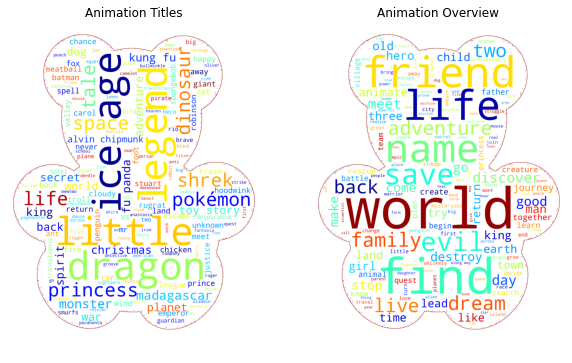

In [221]:
stopwords = ['movie', 'home', 'boy', 'lose', 'face', 'young', 'human', 'get', 
             'one', 'must', 'set', 'take', 'become', 'help', 'force', 'new']
generate_wordcloud(df_wc['titles'].iloc[0], df_wc['overviews'].iloc[0], 
                   'Animation Titles', 'Animation Overview', 
                   mask=maskable_image, cont_color='brown', colormap='jet')

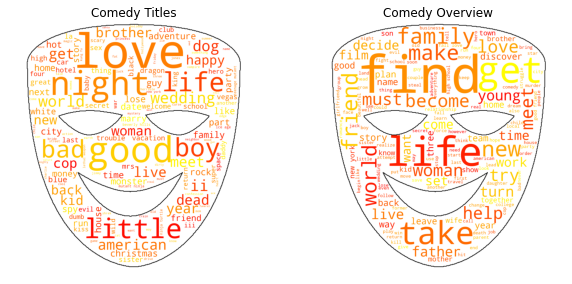

In [222]:
comedy_image = np.array(Image.open('comedy.png'))
comedy_mask = np.ndarray((comedy_image.shape[0],comedy_image.shape[1]), np.int32)
for i in range(len(comedy_image)):
    comedy_mask[i] = list(map(transform_zeros, comedy_image[i]))

stopwords = ['movie', 'mr', 'big', 'man', 'girl', 'go', 'day', 'one', 'two']
generate_wordcloud(df_wc['titles'].iloc[1], df_wc['overviews'].iloc[1], 
                         'Comedy Titles', 'Comedy Overview',
                         mask=comedy_mask, colormap='autumn')

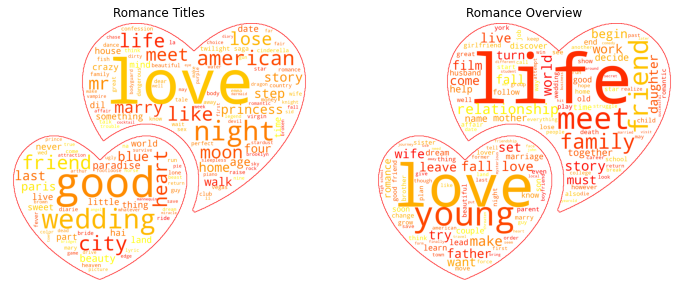

In [223]:
romance_image = np.array(Image.open('romance.png'))
romance_mask = np.ndarray((romance_image.shape[0],romance_image.shape[1]), np.int32)
for i in range(len(romance_image)):
    romance_mask[i] = list(map(transform_zeros, romance_image[i]))

stopwords = ['man', 'woman', 'girl', 'new', 'big', 'get', 'find', 'go', 'two', 
             'one', 'day', 'three', 'take', 'become', 'year', 'boy', 'back']
generate_wordcloud(df_wc['titles'].iloc[6], df_wc['overviews'].iloc[6], 
                   'Romance Titles', 'Romance Overview',
                   mask=romance_mask, colormap='autumn', fig_size=(12,14),
                   cont_color='red', contour_width=3)

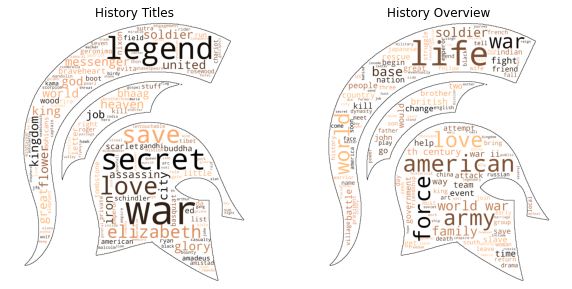

In [224]:
history_image = np.array(Image.open('history.png'))
history_mask = np.ndarray((history_image.shape[0],history_image.shape[1]), np.int32)
for i in range(len(history_image)):
    history_mask[i] = list(map(transform_zeros, history_image[i]))

stopwords = ['man', 'film', 'story', 'ip', 'good', 'lead', 'become', 'set', 'one', 
             'find', 'last', 'first', 'red', 'take', 'new', 'young', 'true', 
             'year', 'tale', 'long', 'part', 'make', 'hour']
generate_wordcloud(df_wc['titles'].iloc[10], df_wc['overviews'].iloc[10], 
                   'History Titles', 'History Overview', mask=history_mask, 
                   colormap='copper', contour_width=3)

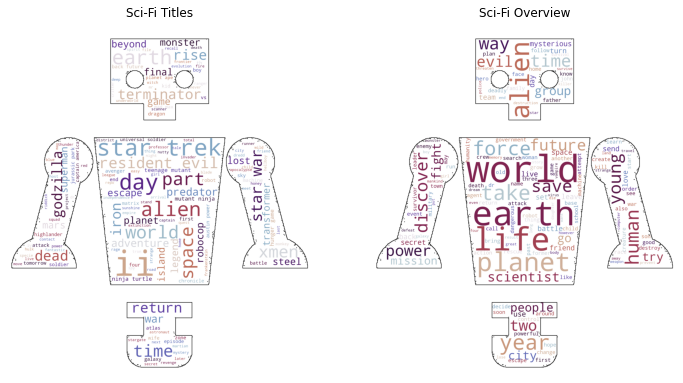

In [225]:
scifi_image = np.array(Image.open('scifi.png'))
scifi_mask = np.ndarray((scifi_image.shape[0],scifi_image.shape[1]), np.int32)
for i in range(len(scifi_image)):
    scifi_mask[i] = list(map(transform_zeros, scifi_image[i]))

stopwords = ['man', 'film', 'movie', 'one', 'iii', 'black', 'make', 'find',
             'must', 'stop', 'new', 'begin', 'lead', 'dark', 'come', 'get',
             'become', 'help']
generate_wordcloud(df_wc['titles'].iloc[11], df_wc['overviews'].iloc[11], 
                   'Sci-Fi Titles', 'Sci-Fi Overview', mask=scifi_mask, 
                   colormap='twilight_shifted', contour_width=4, fig_size=(12,16))

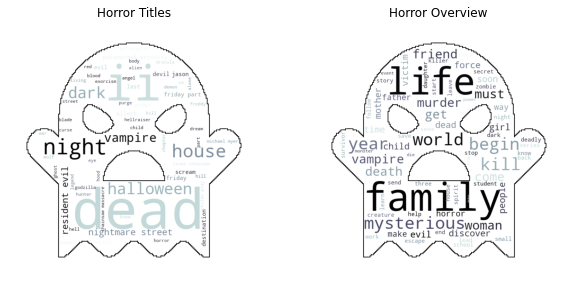

In [227]:
horror_image = np.array(Image.open('horror.png'))
horror_mask = np.ndarray((horror_image.shape[0],horror_image.shape[1]), np.int32)
for i in range(len(horror_image)):
    horror_mask[i] = list(map(transform_zeros_2, horror_image[i]))

stopwords = ['see', 'find', 'th', 'elm', 'see', 'live', 'turn', 'take', 'become', 
             'one', 'new', 'two', 'son', 'man', 'human', 'group', 'return', 
             'young', 'town', 'try', 'go', 'day', 'final', 'home', 'film', 'iii']
generate_wordcloud(df_wc['titles'].iloc[13], df_wc['overviews'].iloc[13], 
                   'Horror Titles', 'Horror Overview', mask=horror_mask, 
                   colormap='bone', contour_width=1)